# MinION based Detection Software {MINDS} 
### jupyter notebook based edition

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import seaborn as sns
import csv

#### Display PyQT widget to enable the end user to select a fastq file

In [2]:
%gui qt

from PyQt5.QtWidgets import QFileDialog

def gui_fname(dir=None):
    """Select a file via a dialog and return the file name."""
    if dir is None: dir ='./'
    fname = QFileDialog.getOpenFileName(None, "Select fastq file...", 
                dir, filter="All files (*);; fastq Files (*.fastq)")
    return fname[0]

In [3]:
# fastq file to be analyzed
fastq_file=gui_fname('')
print("File selected:"+fastq_file)

File selected:/home/samir/projects/MINDS/fastq/EColi_filtered.fq


In [4]:
samplename_w_ext = os.path.basename(fastq_file)
samplename, file_extension = os.path.splitext(samplename_w_ext)
print(samplename)

EColi_filtered


### Make sure you have downloaded the pre-built centrifuge indexes as mentioned in README
### Copy / move the pre-built indexes (cf files) into the centrifuge_db folder
### Edit the cell below to reflect the path and name

In [5]:
# Is there cf files in the centrifuge_db folder?
# centrifuge database file

db_file="~/projects/MINDS/centrifuge_db/p_compressed_h_v/p_compressed+h+v"


In [6]:
# input files on macOS have differet path so be mindful of that.
# Results file has all the reads info & has 8 columns
# Report file has the centrfuge report and has 7 columns

fldresults='~/projects/MINDS/centrifuge_rslts/'
Resultfile=fldresults+samplename+'_results.txt'
Reportfile=fldresults+samplename+'_report.txt'
print(Reportfile)


~/projects/MINDS/centrifuge_rslts/EColi_filtered_report.txt


In [7]:
%timeit
! centrifuge -x {db_file} -q {fastq_file} -t -p 8 -S {Resultfile} --report-file {Reportfile} --exclude-taxids 9606 --mm 
# exclude human hits from the search.

Time loading forward index: 00:00:00
Time loading reference: 00:00:00
Multiseed full-index search: 00:12:31
Time searching: 00:12:31
report file /home/samir/projects/MINDS/centrifuge_rslts/EColi_filtered_report.txt
Number of iterations in EM algorithm: 0
Probability diff. (P - P_prev) in the last iteration: 0
Calculating abundance: 00:00:00
Overall time: 00:12:42


In [8]:
# output files are defined here

ofile=''
file2="_MINDS_Report.csv"

fig1="_MINDS-HeatMap.png"
fig2="_MINDS-PieChart.png"
fig3="_MINDS-Histogram.png"

# dataframes are defined here
dfResult=pd.read_csv(Resultfile,sep="\t")
dfReport=pd.read_csv(Reportfile,sep="\t")

In [9]:
# Extract the sample & path information here
from os.path import expanduser

Sample=os.path.basename(Reportfile)
Sample=os.path.splitext(Sample)[0]
S_path=os.path.dirname(Reportfile)
S_path=expanduser(S_path)
#print(S_path)
# compute the abundance
dfReport['abundance']= dfReport['numUniqueReads']*100 / dfReport['numReads']
# count the number of unclassified reads in the dfResult
dfUnC=dfResult[dfResult.taxID ==0]
unc_reads=dfUnC.shape[0]
Unc_Results=dfResult.groupby('readID').size()


In [10]:
count_reads= dfResult.shape[0]  # gives number of row count from dfResult
Unique_reads=dfResult.groupby(['readID']).size().count()
# minimum reads the organims should have in the dfReport
mini_reads =round((Unique_reads /(10*100))) # Lower this number from 10 if your output results are too strict
print("Your analyzing:",Sample)
print("Folder information:",S_path)
print("Number of reads mapped:", count_reads)
print("Total reads:",Unique_reads)
print("Minimum number of reads:",mini_reads)
print("Duplicate reads:",count_reads-Unique_reads)
# compute threshold
thrshold=(unc_reads/count_reads)*100
print("Sample Threshold cutoff:",thrshold)

Your analyzing: EColi_filtered_report
Folder information: /home/samir/projects/MINDS/centrifuge_rslts
Number of reads mapped: 87793
Total reads: 87619
Minimum number of reads: 88.0
Duplicate reads: 174
Sample Threshold cutoff: 0.007973300832640416


In [11]:
# dfReport.numReads > 0 will provide all reads
# you can filter them by using dfReports > mini_reads instead of dfReports >0.
# uncomment or comment the line in this cell
#dfData=dfReport.loc[dfReport.numReads > mini_reads ,['name','taxID','taxRank','genomeSize','numReads','numUniqueReads','abundance']]
dfData=dfReport.loc[dfReport.numReads > 0 ,['name','taxID','taxRank','genomeSize','numReads','numUniqueReads','abundance']]

In [12]:
# define the filters and cutoff here, edit as neccessary
dfData=dfData.loc[dfData.taxRank =='species'] # default species
dfData=dfData.loc[dfData.numUniqueReads>=15] # default 5
dfData=dfData.loc[dfData.abundance > 80] # default 80

In [13]:
count_results=dfData.shape[0]
print("Found total number of organism:",count_results)

Found total number of organism: 1


In [14]:
# Compute abundance score for unique reads

dfData=dfData.assign(reads_abundance= dfData['numUniqueReads']*100 / Unique_reads)
dfData2=dfData[["name","taxID","abundance","reads_abundance"]]
dfResult1=dfResult.groupby("taxID").agg({'seqID':'size','score':'mean'}).reset_index()
dfResult1=dfResult1.assign(score_abundance= dfResult1['seqID'] / dfResult1['score'])

dfData3=pd.merge(dfData2,dfResult1,left_on='taxID', right_on='taxID')
dfData3=dfData3[["name","taxID","abundance","reads_abundance","score_abundance"]]


In [15]:
# Grade the abundance here, Report card is made in this cell
grades = []

# For each row in the column,
for row in dfData3['abundance']:
    # if more than a value,
    if row >= 90:
        # Append a letter grade
        grades.append('A')
    elif row >= 80:
        # Append a letter grade
        grades.append('B')
    # else, if more than a value,
    elif row >= 70:
        # Append a letter grade
        grades.append('C')
    elif row >= 60:
        # Append a letter grade
        grades.append('D')
    # otherwise,
    else:
        # Append a failing grade
        grades.append('F')
        
# Create a column from the list
dfData3['grades'] = grades
dfData3.drop('score_abundance', axis=1, inplace=True)
dfData3.sort_values('abundance',ascending=False)
#"Save the Report"
ofile=S_path+"/"+Sample+file2

dfData3.to_csv(ofile,sep=',',index=False)
dfData3.sort_values("abundance",ascending=False)

,name,taxID,abundance,reads_abundance,grades
0,Escherichia coli,562,99.897057,99.678152,A


/home/samir/projects/MINDS/centrifuge_rslts/EColi_filtered_report_MINDS-HeatMap.png


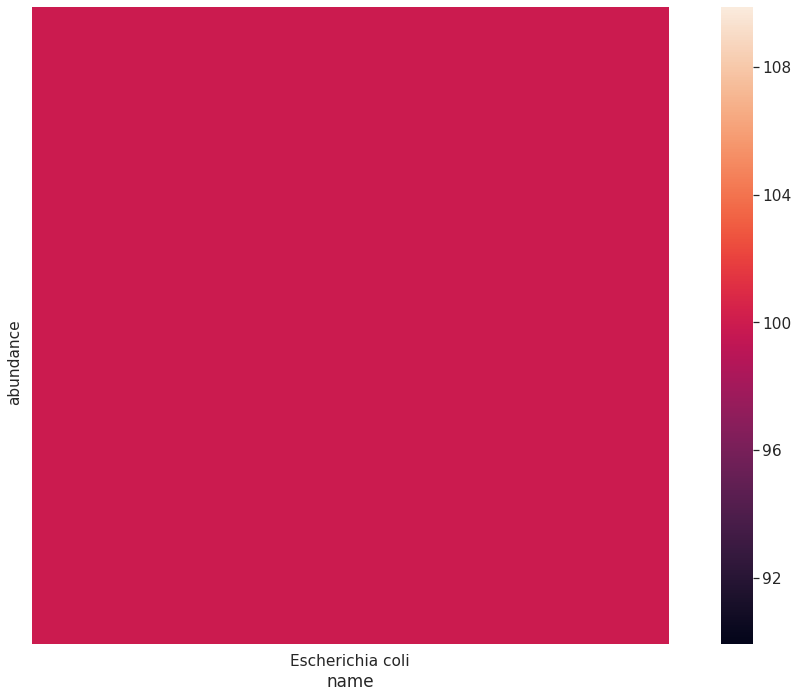

In [16]:
#plot the heatmap for organims to abundance

piv = pd.pivot_table(dfData3, values="abundance", columns=["name"], fill_value=0)

#plot pivot table as heatmap using seaborn
sns.set(font_scale=1.4)
plt.figure(figsize=(15, 10))
ax = sns.heatmap(piv, square=True,xticklabels=1,annot_kws={"size": 16})
plt.setp( ax.yaxis.get_majorticklabels(), rotation=90 )
plt.tight_layout()

#"Save the Report"
Myfig1=S_path+"/"+Sample+fig1
print(Myfig1)
plt.savefig(Myfig1)
plt.show()
plt.close()

In [17]:
dfData3.to_csv("MINDS_results.csv",index=False,encoding='utf-8')

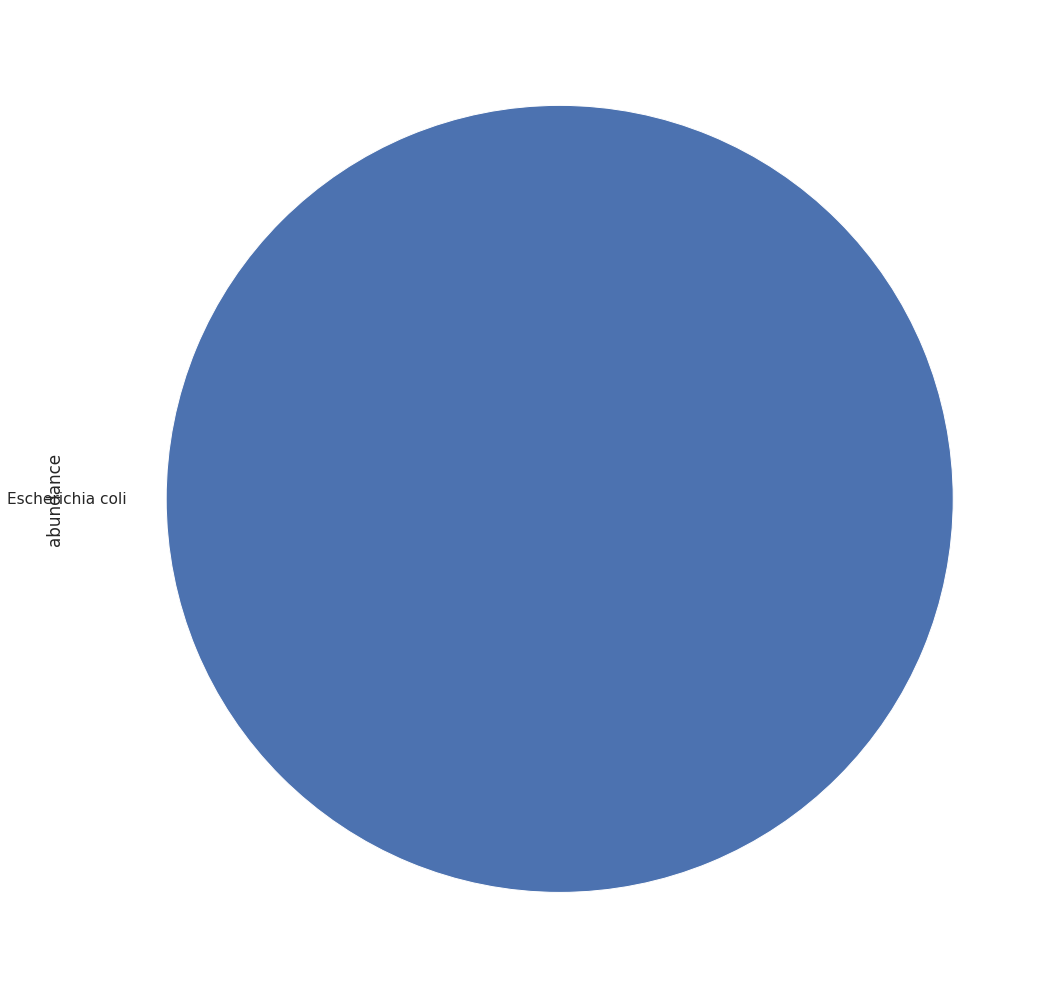

In [18]:
plot = dfData3.plot.pie(y='abundance', labels=dfData3["name"],figsize=(15, 15),legend=False)

plt.tight_layout()
#"Save the Report"
Myfig2=S_path+"/"+Sample+fig2
plt.savefig(Myfig2)
plt.show()

In [19]:
dfData3.sort_values('name',axis=0,ascending=False,inplace=True)

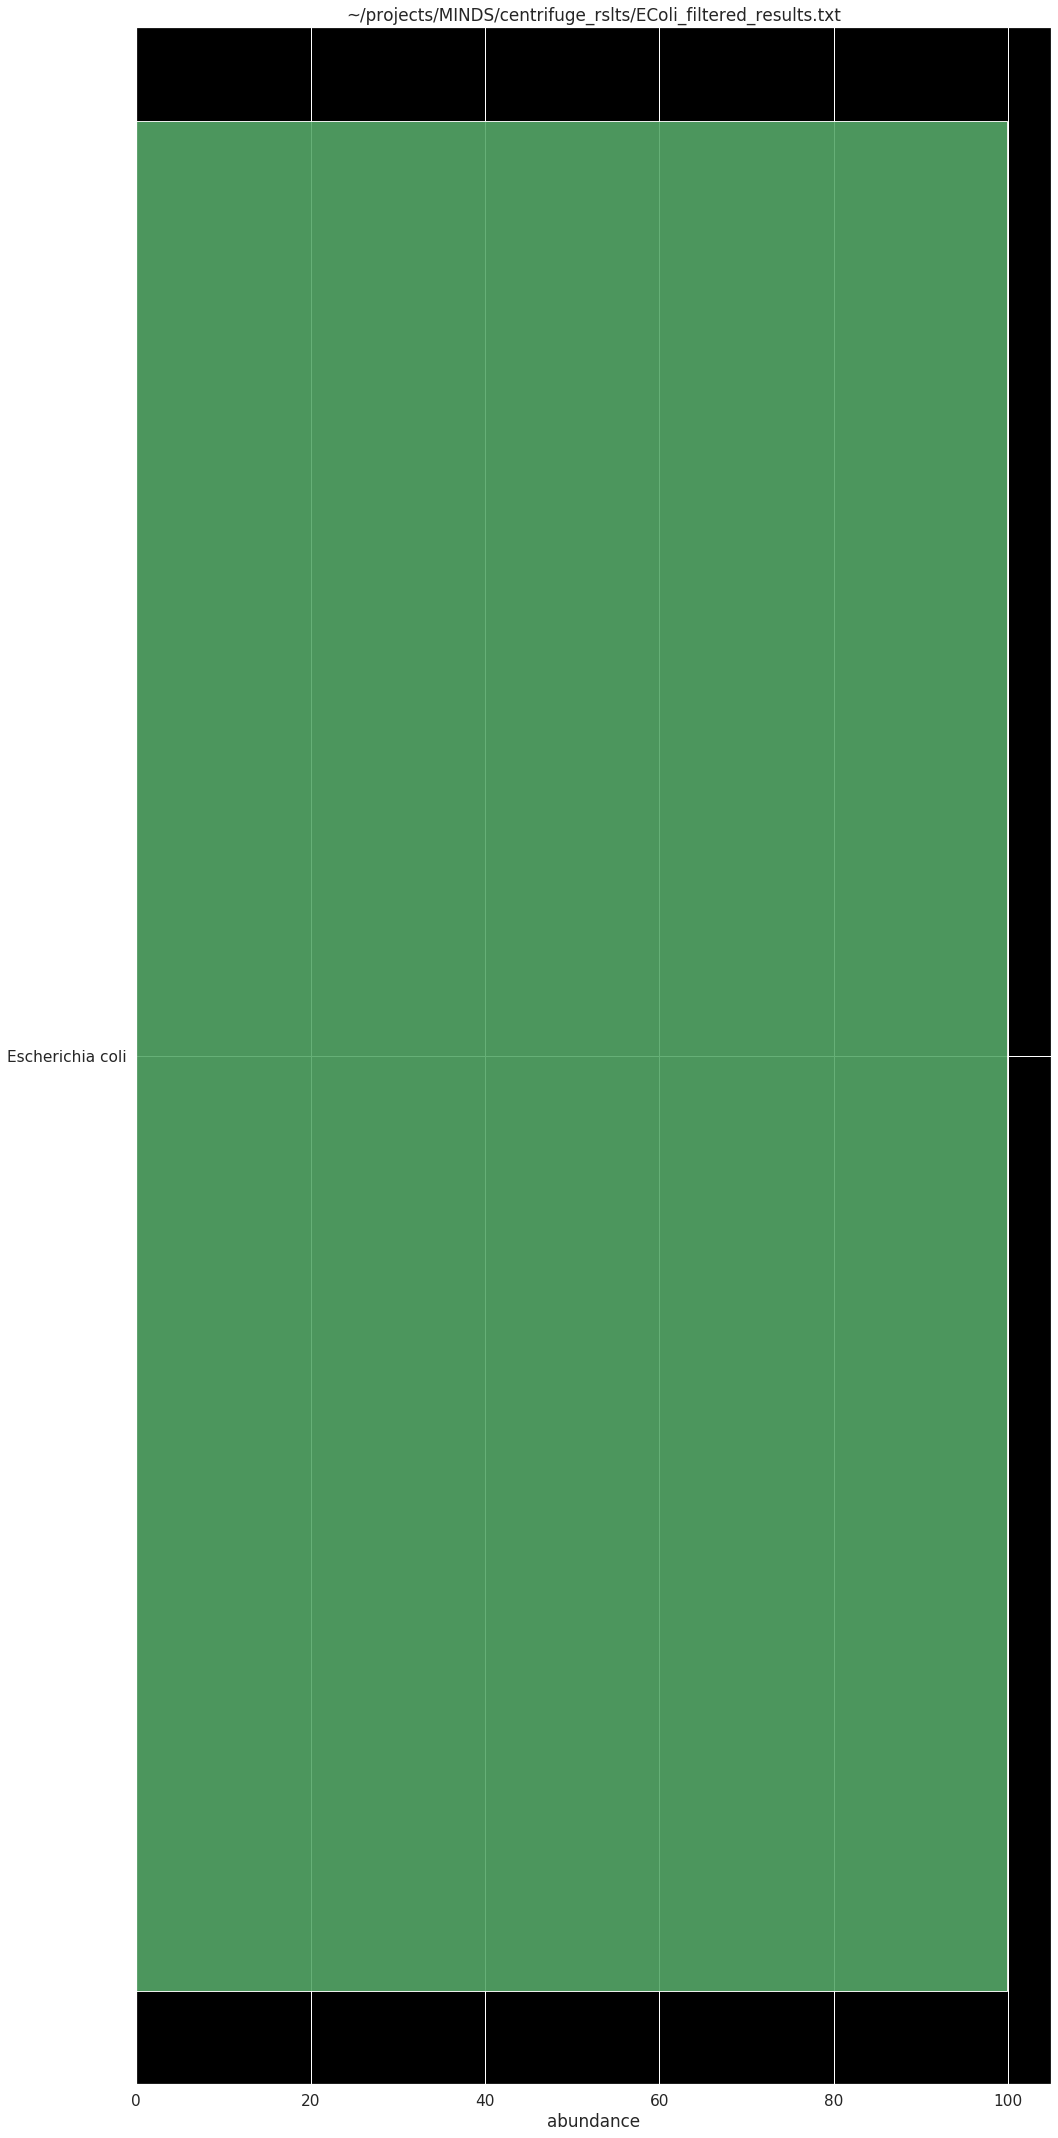

In [20]:
organism=dfData3['name']
y_pos=np.arange(len(organism))
howmuch=dfData3['abundance']

plt.rcParams["axes.facecolor"]="black"
plt.rcParams["figure.facecolor"]="w"
plt.figure(figsize=(15,30))

#Change the color of bar based on the grade"
plt.barh(y_pos,howmuch,alpha=0.9,color=np.where(dfData3['abundance']>60,'g','r'))
plt.yticks(y_pos,organism)
plt.xlabel('abundance')
plt.title(Resultfile)
plt.tight_layout()

#"Save the Report"
Myfig3=S_path+"/"+Sample+fig3
plt.savefig(Myfig3)
plt.show()

In [21]:
## ReportLab to generate summary report
from reportlab.platypus import SimpleDocTemplate,Image
from reportlab.platypus import Paragraph,Table,TableStyle,Spacer, PageBreak
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors
from reportlab.lib.units import inch, cm
from io import BytesIO
pdf_buffer = S_path+'/'+Sample+'_MINDS_Report.pdf'
my_doc = SimpleDocTemplate(pdf_buffer)
flowables = []

my_doc.build(flowables)

sample_style_sheet=getSampleStyleSheet()
paragraph_1 = Paragraph("MINDS Summary Report", sample_style_sheet['Heading1'])
paragraph_2 = Paragraph("Sample:"+samplename,sample_style_sheet['Heading2'])
paragraph_3=Paragraph("Total reads: "+str(Unique_reads)+"; Minimum number of reads: "+str(mini_reads).split('.')[0]+"; Sample Threshold cutoff(%): "+str(thrshold).split('.')[0],sample_style_sheet['BodyText'])

flowables.append(paragraph_1)
flowables.append(paragraph_2)
flowables.append(paragraph_3)

# Images are inserted here

histogram = Image(Myfig3)
histogram.drawHeight =  5.5*inch
histogram.drawWidth = 4.5*inch

piechart= Image(Myfig2)
piechart.drawHeight =  3.5*inch
piechart.drawWidth = 3.5*inch

heatmap= Image(Myfig1)
heatmap.drawHeight =  5.5*inch
heatmap.drawWidth = 4.5*inch

# Read the csv file and print it into the report

#PDF document layout
table_style = TableStyle([('ALIGN',(1,1),(-2,-2),'RIGHT'),
                       ('TEXTCOLOR',(1,1),(-2,-2),colors.red),
                       ('VALIGN',(0,0),(0,-1),'TOP'),
                       ('TEXTCOLOR',(0,0),(0,-1),colors.blue),
                       ('ALIGN',(0,-1),(-1,-1),'CENTER'),
                       ('VALIGN',(0,-1),(-1,-1),'MIDDLE'),
                       ('TEXTCOLOR',(0,-1),(-1,-1),colors.green),
                       ('INNERGRID', (0,0), (-1,-1), 0.25, colors.black),
                       ('BOX', (0,0), (-1,-1), 0.25, colors.black),
                       ])
styles = getSampleStyleSheet() 
styleNormal = styles['Normal']
styleHeading = styles['Heading1']
styleHeading2 = styles['Heading2'] 
styleHeading.alignment = 1 # centre text (TA_CENTRE) 

#Configure style and word wrap
s = getSampleStyleSheet()
s = s["BodyText"]
s.wordWrap = 'CJK'

# File that must be written to report
with open (ofile, 'r') as csvfile:
    reader = csv.reader(csvfile)
    lista = list(reader)

headers = lista[0]

conteo = 1

for numRecord in range(1,len(lista)):

    record1 = lista[numRecord]

    data = list()
    emptyRecords = list()
    records = list()
    header = list()

    countRecords = 0

    for line in record1:

        if line == '':
            emptyRecords.append(line)           
        else:
            records.append(line)
            header.append(headers[countRecords])

            data.append([str(headers[countRecords]), str(line)])

        countRecords = countRecords + 1
    data2 = [[Paragraph(cell, s) for cell in row] for row in data]
    t = Table(data2)
    t.setStyle(table_style)
    flowables.append(t)
#-------------------------------------------------------

flowables.append(Spacer(inch, .25*inch))
flowables.append(heatmap)
flowables.append(piechart)
flowables.append(histogram)

my_doc.build(flowables)

In [24]:
print("Analysis completed & Report generated in the folder ",S_path)

Analysis completed & Report generated in the folder  /home/samir/projects/MINDS/centrifuge_rslts
